In [1]:
import fastai
import torch

In [2]:
from fastai.vision import *
import torch.nn.functional as F
from fastai.layers import *

In [3]:
transforms = get_transforms(do_flip=False, max_rotate=5.0, max_zoom=1.0,
    max_warp=0.0) # Todo look at these
DATA_PATH = "C:/Code/Senior Project"
data = ImageItemList.from_csv(DATA_PATH, "labels.csv")

In [4]:
data = (data.random_split_by_pct()
            .label_from_df(cols=["throttle", "direction"],  label_cls=FloatList)
            .transform(transforms, size=224)
            .databunch())

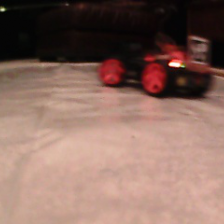

In [6]:
val_ds = data.valid_ds
img, label = val_ds[1]
img

In [12]:
reg_head = torch.nn.Sequential(Flatten(), torch.nn.Linear(25088, 2), SigmoidRange(-1, 1))
learn = create_cnn(data, models.resnet18, metrics=[], custom_head=reg_head, loss_func=F.mse_loss)

In [13]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList
y: FloatList (2531 items)
[FloatItem [0. 0.], FloatItem [0. 0.], FloatItem [0. 0.], FloatItem [1. 0.], FloatItem [1. 0.]]...
Path: C:\Code\Senior Project
x: ImageItemList (2531 items)
[Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320)]...
Path: C:\Code\Senior Project;

Valid: LabelList
y: FloatList (632 items)
[FloatItem [0. 0.], FloatItem [ 1. -1.], FloatItem [1. 0.], FloatItem [0. 0.], FloatItem [0. 0.]]...
Path: C:\Code\Senior Project
x: ImageItemList (632 items)
[Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320), Image (3, 240, 320)]...
Path: C:\Code\Senior Project;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): M

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


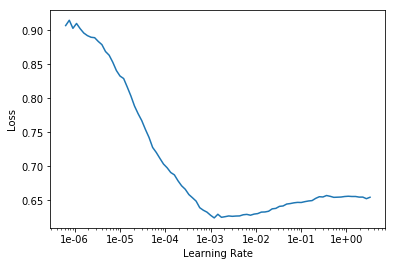

In [10]:
learn.recorder.plot()

In [14]:
epochs = 5
lr = 5e-4 # chosen using lr plot 
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss
1,0.477478,0.417300
2,0.436502,0.478938
3,0.416878,0.388651
4,0.379632,0.383909
5,0.357337,0.370713


In [16]:
learn.save("supervised", with_opt=False)

In [17]:
learn.unfreeze()

In [18]:
epochs = 3
lr = 1e-4 # lower on unfreeze
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss
1,0.362800,0.411872
2,0.375199,0.308880
3,0.301606,0.255149


In [19]:
learn.save("supervised", with_opt=False)

In [20]:
learn.predict(img)

(FloatItem [ 0.894858 -0.432463],
 tensor([ 0.8949, -0.4325]),
 tensor([ 0.8949, -0.4325]))

In [21]:
print(label)

[ 1. -1.]
